<a href="https://www.kaggle.com/code/danuherath/insurance-premium-predict-regression?scriptVersionId=218265845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center"> Regression with an Insurance Dataset (Regression)</h1>

<img
    src="https://www.kaggle.com/competitions/84896/images/header"
    alt=""
    width="300"
    height="200"
    style="display: block; margin: 0 auto; border-radius:15px"
/>

---

## Problem Definition

- Domain

    * Insurance | Finance

<br>

- Dataset
    * [Regression with an Insurance Dataset](https://www.kaggle.com/competitions/playground-series-s4e12/data) dataset from Kaggle which contains 19 features explaining an individaul's demographics, professional and educational background and insurance payments related information. Train dataset contains 1,200,0000 samples and each instance represents one person.

<br>

- Objective
    * The goal of this project is to predict insurance premiums based on various factors.

<br>

- Algorithms
    * Following regressiion algorithms are used to train models on the train dataset. The models are evaluated using the [Root Mean Squared Logarithmic Error (RMSLE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_log_error.html) metric.

    1. [XGBoost (Extreme Gradient Boosting)Regressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)
    2. [LightGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)
    3. [CatBoostRegressor](https://catboost.ai/docs/en/concepts/python-reference_catboostregressor)

<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
%config InlineBackend.figure_format="svg"

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna

RSEED = 42


In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")


In [3]:
train_data.head()


id   Age  Gender  Annual Income Marital Status  Number of Dependents  \
0   0  19.0  Female        10049.0        Married                   1.0   
1   1  39.0  Female        31678.0       Divorced                   3.0   
2   2  23.0    Male        25602.0       Divorced                   3.0   
3   3  21.0    Male       141855.0        Married                   2.0   
4   4  21.0    Male        39651.0         Single                   1.0   

  Education Level     Occupation  Health Score  Location  ... Previous Claims  \
0      Bachelor's  Self-Employed     22.598761     Urban  ...             2.0   
1        Master's            NaN     15.569731     Rural  ...             1.0   
2     High School  Self-Employed     47.177549  Suburban  ...             1.0   
3      Bachelor's            NaN     10.938144     Rural  ...             1.0   
4      Bachelor's  Self-Employed     20.376094     Rural  ...             0.0   

   Vehicle Age  Credit Score  Insurance Duration           Policy Start Date  \
0         17.0         372.0                 5.0  2023-12-23 15:21:39.134960   
1         12.0         694.0                 2.0  2023-06-12 15:21:39.111551   
2         14.0           NaN                 3.0  2023-09-30 15:21:39.221386   
3          0.0         367.0                 1.0  2024-06-12 15:21:39.226954   
4          8.0         598.0                 4.0  2021-12-01 15:21:39.252145   

  Customer Feedback Smoking Status Exercise Frequency Property Type  \
0              Poor             No             Weekly         House   
1           Average            Yes            Monthly         House   
2              Good            Yes             Weekly         House   
3              Poor            Yes              Daily     Apartment   
4              Poor            Yes             Weekly         House   

  Premium Amount  
0         2869.0  
1         1483.0  
2          567.0  
3          765.0  
4         2022.0  

[5 rows x 21 columns]

In [4]:
test_data.head()


id   Age  Gender  Annual Income Marital Status  Number of Dependents  \
0  1200000  28.0  Female         2310.0            NaN                   4.0   
1  1200001  31.0  Female       126031.0        Married                   2.0   
2  1200002  47.0  Female        17092.0       Divorced                   0.0   
3  1200003  28.0  Female        30424.0       Divorced                   3.0   
4  1200004  24.0    Male        10863.0       Divorced                   2.0   

  Education Level     Occupation  Health Score  Location    Policy Type  \
0      Bachelor's  Self-Employed      7.657981     Rural          Basic   
1        Master's  Self-Employed     13.381379  Suburban        Premium   
2             PhD     Unemployed     24.354527     Urban  Comprehensive   
3             PhD  Self-Employed      5.136225  Suburban  Comprehensive   
4     High School     Unemployed     11.844155  Suburban        Premium   

   Previous Claims  Vehicle Age  Credit Score  Insurance Duration  \
0              NaN         19.0           NaN                 1.0   
1              NaN         14.0         372.0                 8.0   
2              NaN         16.0         819.0                 9.0   
3              1.0          3.0         770.0                 5.0   
4              NaN         14.0         755.0                 7.0   

            Policy Start Date Customer Feedback Smoking Status  \
0  2023-06-04 15:21:39.245086              Poor            Yes   
1  2024-04-22 15:21:39.224915              Good            Yes   
2  2023-04-05 15:21:39.134960           Average            Yes   
3  2023-10-25 15:21:39.134960              Poor            Yes   
4  2021-11-26 15:21:39.259788           Average             No   

  Exercise Frequency Property Type  
0             Weekly         House  
1             Rarely     Apartment  
2            Monthly         Condo  
3              Daily         House  
4             Weekly         House

In [5]:
train_data.columns


Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [6]:
train_data.drop(columns=["id"], inplace=True)
test_data.drop(columns=["id"], inplace=True)


---

# Step 1: Exploratory Data Analysis (EDA)

---

In [7]:
print(f"Train Data\nInstance Count: {train_data.shape[0]} \nFeature Count: {train_data.shape[1]-1}")

train_data.head().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"'
    ).set_properties(**{'min-width': '50px'})


Train Data
Instance Count: 1200000 
Feature Count: 19


In [8]:
print(f"Test Data\nInstance Count: {test_data.shape[0]} \nFeature Count: {test_data.shape[1]}")

test_data.head().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"'
    ).set_properties(**{'min-width': '50px'})


Test Data
Instance Count: 800000 
Feature Count: 19


In [9]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-

In [10]:
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)


Previous Claims         364029
Occupation              358075
Credit Score            137882
Number of Dependents    109672
Customer Feedback        77824
Health Score             74076
Annual Income            44949
Age                      18705
Marital Status           18529
Vehicle Age                  6
Insurance Duration           1
dtype: int64


In [11]:
duplicates = train_data[train_data.duplicated(keep=False)]
print(len(duplicates))
# print(duplicates)


0


In [12]:
train_data.nunique().sort_values(ascending=False)


Health Score            532657
Policy Start Date       167381
Annual Income            88593
Premium Amount            4794
Credit Score               550
Age                         47
Vehicle Age                 20
Previous Claims             10
Insurance Duration           9
Number of Dependents         5
Education Level              4
Exercise Frequency           4
Occupation                   3
Location                     3
Policy Type                  3
Marital Status               3
Customer Feedback            3
Property Type                3
Gender                       2
Smoking Status               2
dtype: int64

In [13]:
cat_features = train_data.select_dtypes(include=["object"]).columns.tolist()
num_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns:\n{cat_features}")
print(f"\nNumerical columns:\n{num_features}")


Categorical columns:
['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Numerical columns:
['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount']


In [14]:
num_features.remove('Premium Amount')
target = 'Premium Amount'


In [15]:
cat_features.remove('Policy Start Date')


In [16]:
for col in cat_features:
    print("Feature:", col)
    print("Missing Value Count:", train_data[col].isnull().sum())
    print(dict(train_data[col].value_counts()), end='\n\n')


Feature: Gender
Missing Value Count: 0
{'Male': 602571, 'Female': 597429}

Feature: Marital Status
Missing Value Count: 18529
{'Single': 395391, 'Married': 394316, 'Divorced': 391764}

Feature: Education Level
Missing Value Count: 0
{"Master's": 303818, 'PhD': 303507, "Bachelor's": 303234, 'High School': 289441}

Feature: Occupation
Missing Value Count: 358075
{'Employed': 282750, 'Self-Employed': 282645, 'Unemployed': 276530}

Feature: Location
Missing Value Count: 0
{'Suburban': 401542, 'Rural': 400947, 'Urban': 397511}

Feature: Policy Type
Missing Value Count: 0
{'Premium': 401846, 'Comprehensive': 399600, 'Basic': 398554}

Feature: Customer Feedback
Missing Value Count: 77824
{'Average': 377905, 'Poor': 375518, 'Good': 368753}

Feature: Smoking Status
Missing Value Count: 0
{'Yes': 601873, 'No': 598127}

Feature: Exercise Frequency
Missing Value Count: 0
{'Weekly': 306179, 'Monthly': 299830, 'Rarely': 299420, 'Daily': 294571}

Feature: Property Type
Missing Value Count: 0
{'House'

In [17]:
train_data[target].describe()


count    1.200000e+06
mean     1.102545e+03
std      8.649989e+02
min      2.000000e+01
25%      5.140000e+02
50%      8.720000e+02
75%      1.509000e+03
max      4.999000e+03
Name: Premium Amount, dtype: float64

---

## 1.1 Statistical Analysis

---

In [18]:
train_data[num_features].describe().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"').set_properties(**{'min-width': '100px'})


In [19]:
Q1 = train_data[num_features].quantile(0.25)
Q3 = train_data[num_features].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((train_data[num_features] < lower_bound) | (train_data[num_features] > upper_bound))

outliers_count = outliers_iqr.sum()
outliers_count = outliers_count[outliers_count > 0].sort_values(ascending=False)

print(f"Outliers Count: \n{outliers_count}")


Outliers Count: 
Annual Income      67132
Previous Claims      369
dtype: int64


---

## 1.2 Data Visualization

---

---

## 1.2.1 Univariate Analysis¶

---

In [20]:
len(cat_features)


10

In [21]:
n_cols_cat = 2
n_rows_cat = 5


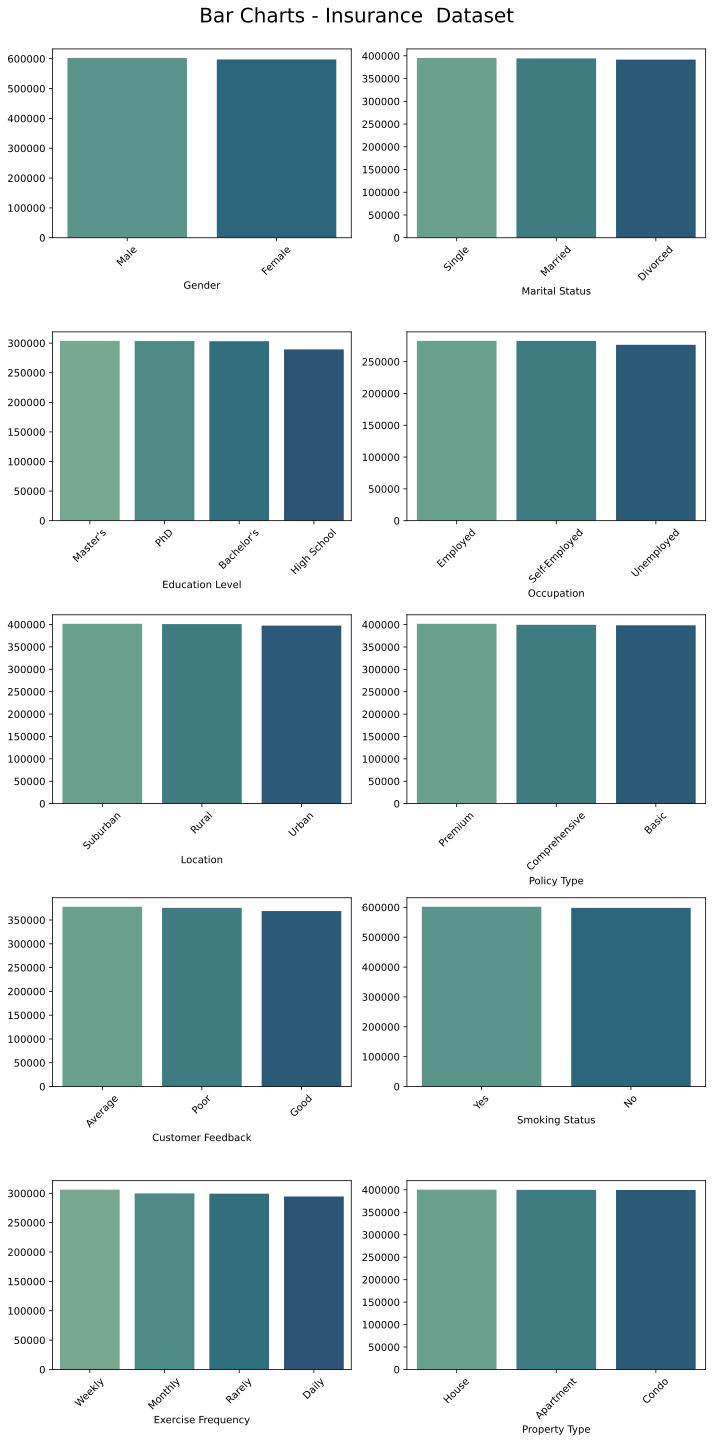

In [22]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 4*n_rows_cat))
axes = axes.flatten()

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    category_counts = train_data[cat_features][column].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, palette="crest")
    ax.set_xticklabels(category_counts.index, rotation=45)

plt.suptitle("Bar Charts - Insurance  Dataset", fontsize=20, y=1.0)

plt.tight_layout()
plt.savefig("Categorical Feature Analysis - Bar Charts.svg")
plt.show()


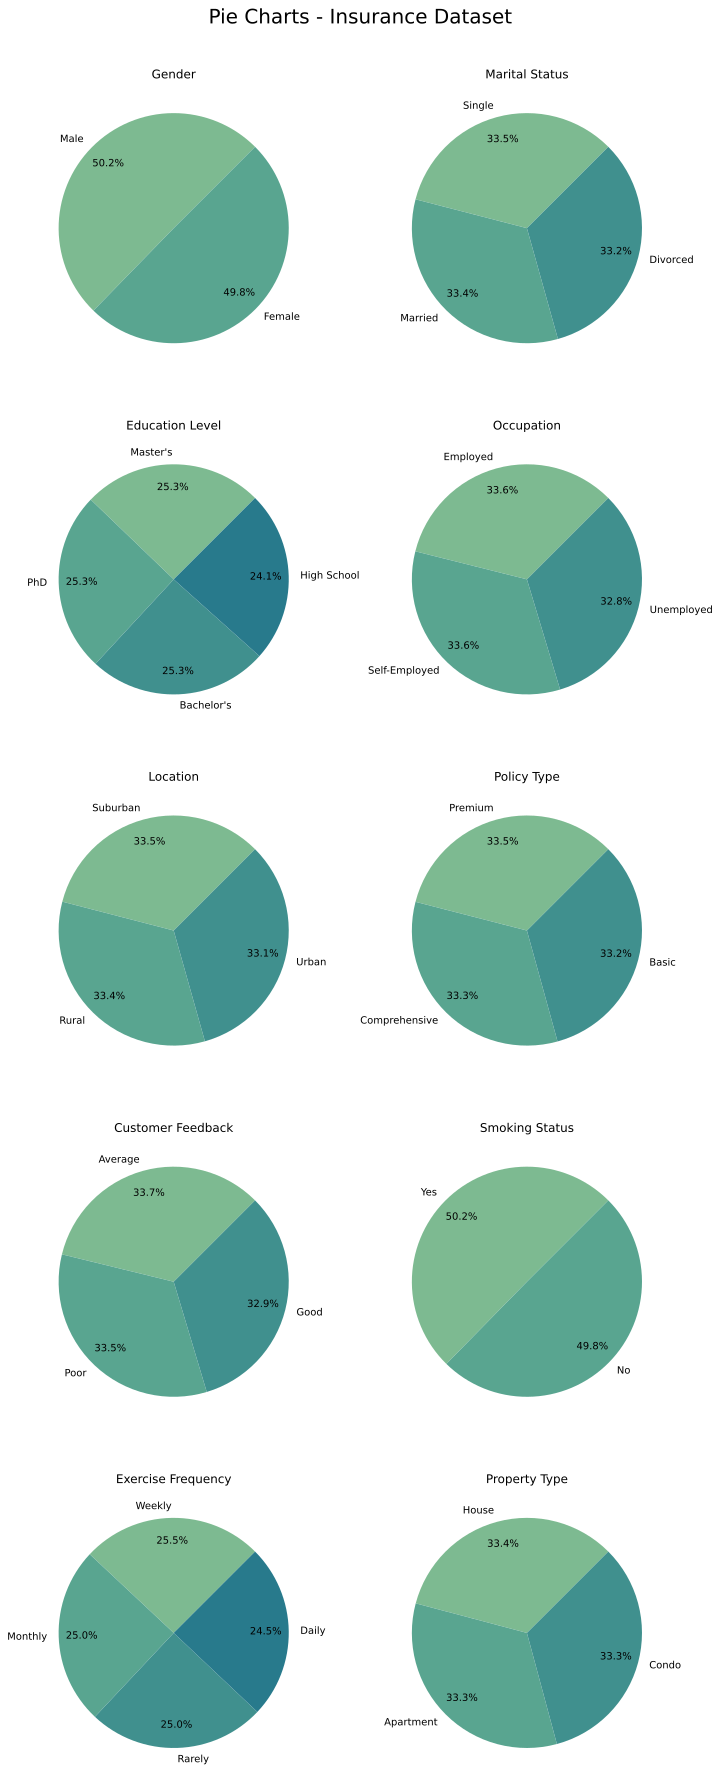

In [23]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 5*n_rows_cat))
axes = axes.flatten()

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    category_counts = train_data[cat_features][column].value_counts()
    ax.pie(
        category_counts.values,
        labels=category_counts.index,
        autopct='%1.1f%%',
        startangle=45,
        colors=sns.color_palette('crest'),
        labeldistance=1.1,
        pctdistance=0.80
    )
    ax.set_title(column)

plt.suptitle('Pie Charts - Insurance Dataset', fontsize=20, y=1.0)

plt.tight_layout()
plt.savefig("Categorical Feature Analysis - Pie Charts.svg")
plt.show()


In [24]:
len(num_features)


8

In [25]:
n_cols_num = 2
n_rows_num = 4


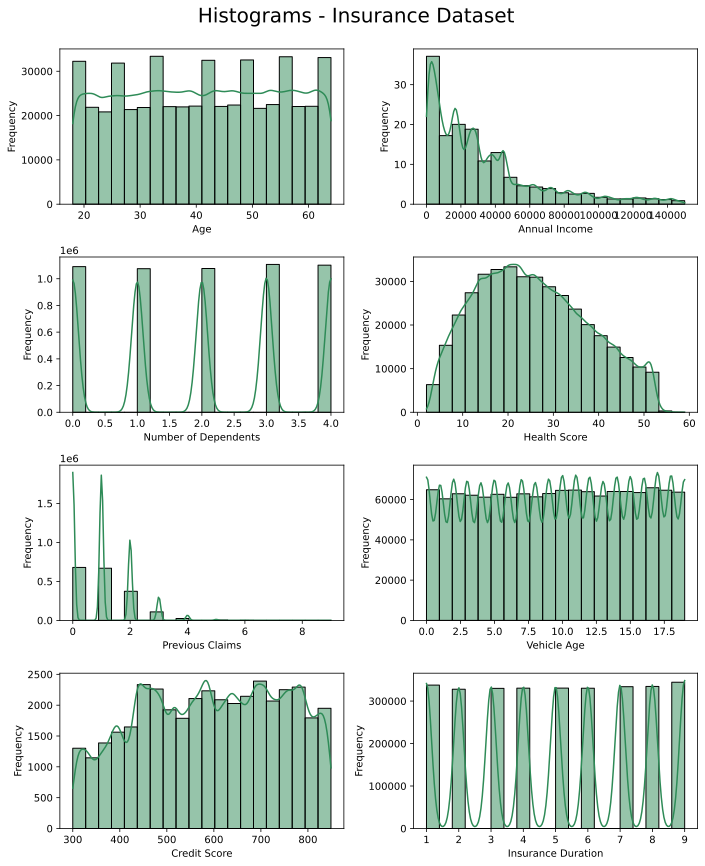

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axes = plt.subplots(n_rows_num, n_cols_num, figsize=(10, 3*n_rows_num))
axes = axes.flatten()

for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.histplot(train_data[num_features][col], ax=ax, color='seagreen', stat='frequency', bins=20, kde=True)
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Histograms - Insurance Dataset', fontsize=20, y=1.0)

plt.tight_layout()
plt.savefig('Numerical Feature Analysis - Histograms.svg')
plt.show()


In [27]:
fig, axes = plt.subplots(n_rows_num, n_cols_num, figsize=(10, 2*n_rows_num))
axes = axes.flatten()

for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.boxplot(x=train_data[num_features][col], ax=ax, color='seagreen')
    ax.set_xlabel(col)
    ax.set_ylabel('Value')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Box Plots - Insurance Dataset', fontsize=20, y=1.0)

plt.tight_layout()
plt.savefig('Numerical Feature Analysis - Box Plots.svg')
plt.show()


---

## 1.2.2 Bivariate Analysis

---

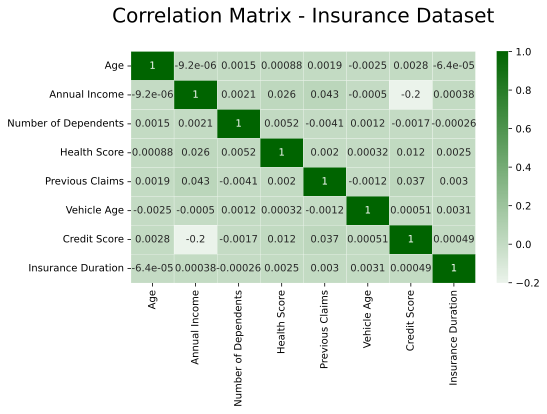

In [28]:
corr = train_data[num_features].corr()
cmap = sns.light_palette("darkgreen", as_cmap=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap=cmap, linewidths=0.2)

plt.title('Correlation Matrix - Insurance Dataset', fontsize=20, y=1.1)

plt.tight_layout()
plt.savefig('Numerical Features Correlation Analysis - Corr Matrix.svg')
plt.show()


---

# Step 2: Data Preprocessing

---

In [29]:
train_data['Policy Start Date'] = pd.to_datetime(train_data['Policy Start Date'])
train_data['Policy Start Date']


0         2023-12-23 15:21:39.134960
1         2023-06-12 15:21:39.111551
2         2023-09-30 15:21:39.221386
3         2024-06-12 15:21:39.226954
4         2021-12-01 15:21:39.252145
                     ...            
1199995   2023-05-03 15:21:39.257696
1199996   2022-09-10 15:21:39.134960
1199997   2021-05-25 15:21:39.106582
1199998   2021-09-19 15:21:39.190215
1199999   2020-08-26 15:21:39.155231
Name: Policy Start Date, Length: 1200000, dtype: datetime64[ns]

In [30]:
# cat_features
# num_features

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),

        ('categorical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
        ]), cat_features)
    ],
    remainder='passthrough'
)

preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Annual Income',
                                  'Number of Dependents', 'Health Score',
                                  'Previous Claims', 'Vehicle Age',
                                  'Credit Score', 'Insurance Duration']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Gender', 'Marital Status', 'Education Level',
                                  'Occupation', 'Location', 'Policy Type',
                                  'Customer Feedback', 'Smoking Status',
                                  'Exercise Frequency', 'Property Type'])])

In [32]:
X = train_data.drop(columns=[target, 'Policy Start Date'])
y = train_data[target]
X.shape, y.shape


((1200000, 18), (1200000,))

In [33]:
X.head()


Age  Gender  Annual Income Marital Status  Number of Dependents  \
0  19.0  Female        10049.0        Married                   1.0   
1  39.0  Female        31678.0       Divorced                   3.0   
2  23.0    Male        25602.0       Divorced                   3.0   
3  21.0    Male       141855.0        Married                   2.0   
4  21.0    Male        39651.0         Single                   1.0   

  Education Level     Occupation  Health Score  Location    Policy Type  \
0      Bachelor's  Self-Employed     22.598761     Urban        Premium   
1        Master's            NaN     15.569731     Rural  Comprehensive   
2     High School  Self-Employed     47.177549  Suburban        Premium   
3      Bachelor's            NaN     10.938144     Rural          Basic   
4      Bachelor's  Self-Employed     20.376094     Rural        Premium   

   Previous Claims  Vehicle Age  Credit Score  Insurance Duration  \
0              2.0         17.0         372.0                 5.0   
1              1.0         12.0         694.0                 2.0   
2              1.0         14.0           NaN                 3.0   
3              1.0          0.0         367.0                 1.0   
4              0.0          8.0         598.0                 4.0   

  Customer Feedback Smoking Status Exercise Frequency Property Type  
0              Poor             No             Weekly         House  
1           Average            Yes            Monthly         House  
2              Good            Yes             Weekly         House  
3              Poor            Yes              Daily     Apartment  
4              Poor            Yes             Weekly         House

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RSEED)


---

# Step 3: Model Training & Evaluation

---

In [35]:

def root_mean_squared_log_error(y_true, y_pred):
    
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    
    squared_diff = (log_true - log_pred) ** 2
    
    return np.sqrt(np.mean(squared_diff))


In [36]:
# models = {
#     'regression_model': LinearRegression(),    # 1.1695
#     'XGBoost': XGBRegressor(random_state=RSEED),    # 1.1495
#     'LGBM': LGBMRegressor(random_state=RSEED),   # 1.1495
#     'CatBoost': CatBoostRegressor(random_state=RSEED)    # 1.1487
# }


In [37]:

# def train_models(X_train, X_val, y_train, y_val, models, preprocessor):
#     results = {}
#     pipelines = {}
    
#     for name, model in models.items():
#         pipeline = make_pipeline(preprocessor, model)

#         pipeline.fit(X_train, y_train)
    
#         y_pred = pipeline.predict(X_val)
        
#         score = root_mean_squared_log_error(y_val, y_pred)
        
#         print(name, score)
        
#         results[name] = score
#         pipelines[name] = pipeline
                
#     return pipelines, results


# pipelines, scores = train_models(X_train, X_val, y_train, y_val, models, preprocessor)


In [38]:

# def objective(trial, X_train, X_val, y_train, y_val, preprocessor):
#     param = {
#         'objective': 'RMSE',
#         'eval_metric': 'RMSE',
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
#         'n_estimators': 300,
#         'random_state': 42,
#         'thread_count': -1
#     }
    
#     model = CatBoostRegressor(**param)
#     pipeline = make_pipeline(preprocessor, model)
#     pipeline.fit(X_train, y_train)
    
#     y_pred = pipeline.predict(X_val)
#     score = mean_squared_error(y_val, y_pred)
    
#     return score


# def tune_catboost(X_train, X_val, y_train, y_val, preprocessor, n_trials=30):
#     study = optuna.create_study(direction='minimize')
#     study.optimize(lambda trial: objective(trial, X_train, X_val, y_train, y_val, preprocessor), n_trials=n_trials)
    
#     print(f'Best trial: {study.best_trial.params}')

#     best_model_params = study.best_trial.params

#     return best_model_params


# best_model_params = tune_catboost(X_train, X_val, y_train, y_val, preprocessor)
# best_model_params


In [39]:
best_model_params = {
    'objective': 'RMSE',
    'eval_metric': 'RMSE',
    'max_depth': 10,
    'subsample': 0.9634787862433333,
    'colsample_bylevel': 0.9158885547943915,
    'min_child_samples': 4,
    'learning_rate': 0.05713686350188332,
    'n_estimators': 300,
    'random_state': 42,
    'thread_count': -1
}

best_model = CatBoostRegressor(**best_model_params)

best_catboost_model = make_pipeline(preprocessor, best_model)
best_catboost_model.fit(X_train, y_train)

y_pred = best_catboost_model.predict(X_val)
score = root_mean_squared_log_error(y_val, y_pred)
score


0:	learn: 863.6135670	total: 207ms	remaining: 1m 1s
1:	learn: 862.2669849	total: 344ms	remaining: 51.3s
2:	learn: 861.0606899	total: 479ms	remaining: 47.4s
3:	learn: 859.9829681	total: 614ms	remaining: 45.4s
4:	learn: 859.0300892	total: 751ms	remaining: 44.3s
5:	learn: 858.2080549	total: 892ms	remaining: 43.7s
6:	learn: 857.4087963	total: 1.02s	remaining: 42.7s
7:	learn: 856.8423074	total: 1.15s	remaining: 42.1s
8:	learn: 856.1629681	total: 1.29s	remaining: 41.8s
9:	learn: 855.5345509	total: 1.43s	remaining: 41.4s
10:	learn: 855.0464513	total: 1.56s	remaining: 41s
11:	learn: 854.5328617	total: 1.7s	remaining: 40.7s
12:	learn: 854.1588695	total: 1.83s	remaining: 40.4s
13:	learn: 853.7702087	total: 1.96s	remaining: 40.1s
14:	learn: 853.2414444	total: 2.1s	remaining: 39.8s
15:	learn: 852.9229215	total: 2.23s	remaining: 39.5s
16:	learn: 852.5872945	total: 2.37s	remaining: 39.5s
17:	learn: 852.1516236	total: 2.5s	remaining: 39.2s
18:	learn: 851.8432693	total: 2.64s	remaining: 39s
19:	learn:

1.1501208457728591

---

# Step 4: Test Data Prediction

---

In [40]:
test_data_predictions = best_catboost_model.predict(test_data)
test_data_predictions

array([1411.16320879, 1102.60515279, 1066.46880438, ..., 1069.77164484,
       1182.13700572, 1047.1500466 ])

In [41]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')
submission[target] = test_data_predictions

submission.to_csv('submission.csv', index=False)
submission.head()


id  Premium Amount
0  1200000     1411.163209
1  1200001     1102.605153
2  1200002     1066.468804
3  1200003     1087.993384
4  1200004     1034.400221